# Train a scVI model using Lamin

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data using [Lamin](https://lamin.ai/) dataloader.
LaminDB is a database system based on its MappedCollection designed to support efficient storage, management, and querying of scientific data, particularly in machine learning, bioinformatics, and data science applications. It allows for the easy organization, sharing, and querying of complex datasets, such as those involved in research, experiments, or models.
See [here](https://docs.scvi-tools.org/en/stable/user_guide/use_case/custom_dataloaders.html) for more information

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import time

import scanpy as sc
import scvi
from scvi.dataloaders import MappedCollectionDataModule

→ connected lamindb: anonymous/lamindb_collection


In [3]:
# os.system("lamin init --storage ./lamindb_collection")  # one time for github runner (comment)
import lamindb as ln
# ln.setup.init()

In [4]:
pbmc_dataset = scvi.data.pbmc_dataset(
    save_path=".",
    remove_extracted_data=True,
)

INFO     File ./gene_info_pbmc.csv already downloaded                                                              
INFO     File ./pbmc_metadata.pickle already downloaded                                                            
INFO     File ./pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc8k/filtered_gene_bc_matrices                                             
INFO     File ./pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc4k/filtered_gene_bc_matrices                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


In [5]:
pbmc_seurat_v4_cite_seq = scvi.data.pbmc_seurat_v4_cite_seq(save_path=".")

INFO     File ./pbmc_seurat_v4.h5ad already downloaded                                                             


In [6]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs.Phase

In [7]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs["batch"].astype("str")
pbmc_dataset.obs["batch"] = pbmc_dataset.obs["batch"].astype("str")

In [8]:
import numpy as np

gene_intersection = np.intersect1d(
    pbmc_dataset.var.gene_symbols.values, pbmc_seurat_v4_cite_seq.var.index.values
)
pbmc_dataset_filtered = pbmc_dataset[:, pbmc_dataset.var["gene_symbols"].isin(gene_intersection)]
pbmc_seurat_v4_cite_seq_filtered = pbmc_seurat_v4_cite_seq[
    :, pbmc_seurat_v4_cite_seq.var_names.isin(gene_intersection)
]

In [9]:
pbmc_dataset_filtered.var_names = pbmc_dataset_filtered.var["gene_symbols"].values

In [10]:
pbmc_dataset_filtered.obs["cell_type"] = pbmc_dataset_filtered.obs["str_labels"].astype("str")
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "FCGR3A+ Monocytes", "cell_type"
] = "Monocytes"
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "CD14+ Monocytes", "cell_type"
] = "Monocytes"
pbmc_dataset_filtered.obs.loc[
    pbmc_dataset_filtered.obs["cell_type"] == "Megakaryocytes", "cell_type"
] = "Other"

In [11]:
pbmc_dataset_filtered

AnnData object with n_obs × n_vars = 11990 × 3315
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'

In [12]:
pbmc_dataset_filtered.obs["cell_type"].value_counts()

cell_type
CD4 T cells        4996
Monocytes          2578
B cells            1621
CD8 T cells        1448
Other               551
NK cells            457
Dendritic Cells     339
Name: count, dtype: int64

In [13]:
pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] = pbmc_seurat_v4_cite_seq_filtered.obs[
    "celltype.l1"
].astype("str")
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "other", "cell_type"
] = "Other"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "B", "cell_type"
] = "B cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "DC", "cell_type"
] = "Dendritic Cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "NK", "cell_type"
] = "NK cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "CD4 T", "cell_type"
] = "CD4 T cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "CD8 T", "cell_type"
] = "CD8 T cells"
pbmc_seurat_v4_cite_seq_filtered.obs.loc[
    pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"] == "Mono", "cell_type"
] = "Monocytes"

/tmp/ipykernel_2629600/3888762861.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pbmc_seurat_v4_cite_seq_filtered.obs['cell_type'] = pbmc_seurat_v4_cite_seq_filtered.obs['celltype.l1'].astype("str")


In [14]:
pbmc_seurat_v4_cite_seq_filtered

AnnData object with n_obs × n_vars = 152094 × 3315
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size', 'batch', 'cell_type'
    var: 'mt'
    obsm: 'protein_counts'

In [15]:
pbmc_seurat_v4_cite_seq_filtered.obs["cell_type"].value_counts()

cell_type
Monocytes          47217
CD4 T cells        40245
CD8 T cells        24399
NK cells           15384
B cells            13192
other T             5828
Dendritic Cells     3488
Other               2341
Name: count, dtype: int64

In [16]:
ln.track()

→ loaded Transform('gyaMpZll3bb20000'), re-started Run('x1BsIvGi...') at 2025-05-05 11:09:50 UTC


In [17]:
# prepare test data
# adata1 = synthetic_iid()
# adata2 = synthetic_iid()

artifact1 = ln.Artifact.from_anndata(pbmc_dataset_filtered, key="part_one1.h5ad").save()
artifact2 = ln.Artifact.from_anndata(pbmc_seurat_v4_cite_seq_filtered, key="part_two1.h5ad").save()

collection = ln.Collection([artifact1, artifact2], key="gather")
collection.save()

→ returning existing artifact with same hash: Artifact(uid='M18k5o0Xe3qDFjOv0005', is_latest=False, key='part_one.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=49787918, hash='Qa1fqQcaprCKNBrFOF1l1g', n_observations=11990, space_id=1, storage_id=1, run_id=1, created_by_id=1, created_at=2025-04-27 15:19:30 UTC); to track this artifact as an input, use: ln.Artifact.get()
! key part_one.h5ad on existing artifact differs from passed key part_one1.h5ad


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


→ returning existing artifact with same hash: Artifact(uid='1DZ49fivMXjvwSiO0004', is_latest=False, key='part_two.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=998889103, hash='DozCh58Pwbgf9-wzsb976e', n_observations=152094, space_id=1, storage_id=1, run_id=1, created_by_id=1, created_at=2025-04-27 15:19:31 UTC); to track this artifact as an input, use: ln.Artifact.get()
! key part_two.h5ad on existing artifact differs from passed key part_two1.h5ad
! returning existing collection with same hash: Collection(uid='6IASvDXmFbji3Uzu0006', is_latest=False, key='gather', hash='wPM0DpO-bWnuNH5Kqd1zEA', space_id=1, created_by_id=1, run_id=1, created_at=2025-04-27 15:19:31 UTC); if you intended to query to track this collection as an input, use: ln.Collection.get()


Collection(uid='6IASvDXmFbji3Uzu0006', is_latest=False, key='gather', hash='wPM0DpO-bWnuNH5Kqd1zEA', space_id=1, created_by_id=1, run_id=1, created_at=2025-04-27 15:19:31 UTC)

In [18]:
# We load the collection to see it consists of many h5ad files
artifacts = collection.artifacts.all()
artifacts.df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
10,M18k5o0Xe3qDFjOv0005,part_one.h5ad,None,.h5ad,dataset,AnnData,49787918,Qa1fqQcaprCKNBrFOF1l1g,None,11990,md5,True,False,1,1,None,None,False,1,2025-04-27 15:19:30.154000+00:00,1,None,1
11,1DZ49fivMXjvwSiO0004,part_two.h5ad,None,.h5ad,dataset,AnnData,998889103,DozCh58Pwbgf9-wzsb976e,None,152094,sha1-fl,True,False,1,1,None,None,False,1,2025-04-27 15:19:31.061000+00:00,1,None,1


In [19]:
# we can now define the batch and data loader
batch_keys = "batch"
datamodule = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    batch_size=1024,
    shuffle=True,
    join="inner",
)

In [20]:
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

164084 3315 5


In [21]:
print(datamodule.registry)

{'scvi_version': '1.3.1', 'model_name': 'SCVI', 'setup_args': {'layer': None, 'batch_key': 'batch', 'labels_key': None, 'size_factor_key': None, 'categorical_covariate_keys': None, 'continuous_covariate_keys': None}, 'field_registries': {'X': {'data_registry': {'attr_name': 'X', 'attr_key': None}, 'state_registry': {'n_obs': 164084, 'n_vars': 3315, 'column_names': Index(['NOC2L', 'ISG15', 'PLCH2', 'PANK4', 'TNFRSF14', 'LRRC47', 'C1orf174',
       'NOL9', 'ZBTB48', 'KLHL21',
       ...
       'WDR4', 'U2AF1', 'CSTB', 'AGPAT3', 'AIRE', 'PTTG1IP', 'ITGB2', 'PCNT',
       'DIP2A', 'S100B'],
      dtype='object', length=3315)}, 'summary_stats': {'n_vars': 3315, 'n_cells': 164084}}, 'batch': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_batch'}, 'state_registry': {'categorical_mapping': {'0': 0, '1': 1, 'G1': 2, 'G2M': 3, 'S': 4}, 'original_key': 'batch'}, 'summary_stats': {'n_batch': 5}}, 'labels': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_labels'}, 'state_regist

In [22]:
# Init the model
model = scvi.model.SCVI(registry=datamodule.registry)

In [23]:
# Training the model
import gc

gc.collect()
start = time.time()
model.train(
    max_epochs=100,
    batch_size=1024,
    plan_kwargs={"lr": 0.003, "compile": False},
    early_stopping=False,
    datamodule=datamodule.inference_dataloader(),
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4096. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 244. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 523.04 seconds


In [24]:
model.history["elbo_train"]

,elbo_train
epoch,
0,2258.675049
1,2052.730469
2,2044.659668
3,2035.111206
4,2023.432983
...,...
95,1853.426392
96,1853.177002
97,1852.798828


In [25]:
# Save the model
model.save("lamin_model", save_anndata=False, overwrite=True, datamodule=datamodule)

In [26]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [27]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_dataloader = datamodule.inference_dataloader()
latent = model.get_latent_representation(dataloader=inference_dataloader)

In [28]:
# We extract the adata of the model, to be able to plot it
adata = collection.load(join="inner")

In [29]:
adata.obsm["scvi"] = latent

In [30]:
# adata.obs['cell_type'] = pbmc_dataset_filtered.obs.str_labels.values.tolist() + pbmc_seurat_v4_cite_seq_filtered.obs['celltype.l1'].values.tolist()

In [31]:
adata.obs

,batch,cell_type,artifact_uid
AAACCTGAGCTAGTGG-1,0,CD4 T cells,M18k5o0Xe3qDFjOv0005
AAACCTGCACATTAGC-1,0,CD4 T cells,M18k5o0Xe3qDFjOv0005
AAACCTGCACTGTTAG-1,0,Monocytes,M18k5o0Xe3qDFjOv0005
AAACCTGCATAGTAAG-1,0,Monocytes,M18k5o0Xe3qDFjOv0005
AAACCTGCATGAACCT-1,0,CD8 T cells,M18k5o0Xe3qDFjOv0005
...,...,...,...
E2L8_TTTGTTGGTCGTGATT,S,CD8 T cells,1DZ49fivMXjvwSiO0004
E2L8_TTTGTTGGTGTGCCTG,G1,Monocytes,1DZ49fivMXjvwSiO0004
E2L8_TTTGTTGGTTAGTTCG,S,B cells,1DZ49fivMXjvwSiO0004
E2L8_TTTGTTGGTTGGCTAT,G1,Monocytes,1DZ49fivMXjvwSiO0004


In [32]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

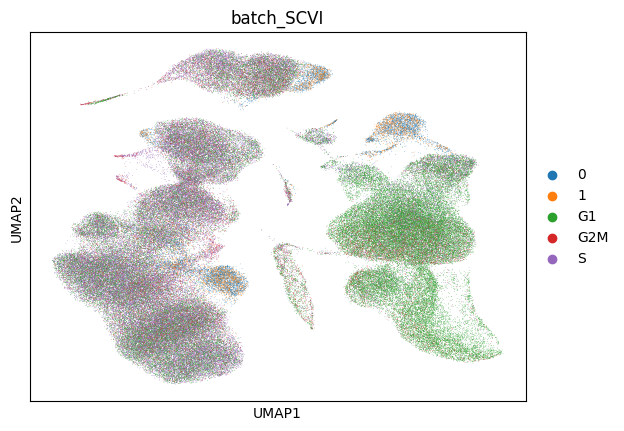

In [33]:
sc.pl.umap(adata, color=batch_keys, title="batch_SCVI")

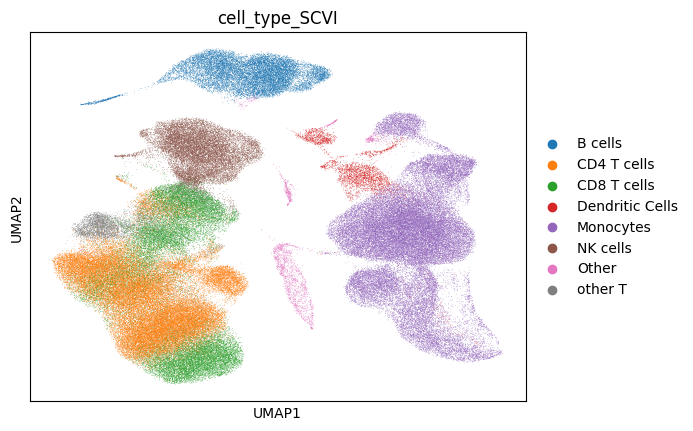

In [34]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI")

## scanvi

In [35]:
labels_keys = "cell_type"
datamodule_scanvi = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    label_key=labels_keys,
    batch_size=1024,
    shuffle=True,
    model_name="SCANVI",
    join="inner",
)
print(
    datamodule_scanvi.n_obs,
    datamodule_scanvi.n_vars,
    datamodule_scanvi.n_batch,
    datamodule_scanvi.n_labels,
)

164084 3315 5 9


In [36]:
# We can now create the scanVI model object and train it:
datamodule_scanvi.setup(stage="train")
model_scanvi = scvi.model.SCANVI(
    adata=None,
    registry=datamodule_scanvi.registry,
    datamodule=datamodule_scanvi,
)

In [37]:
# datamodule_scanvi.registry

In [38]:
# Training the model
import gc

gc.collect()
start3 = time.time()
model_scanvi.train(
    max_epochs=20,
    batch_size=1024,
    plan_kwargs={"lr": 0.01, "compile": False},
    early_stopping=False,
    n_samples_per_label=100,
    datamodule=datamodule_scanvi,
)
end3 = time.time()
print(f"Elapsed time: {end3 - start3:.2f} seconds")

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Elapsed time: 145.14 seconds


In [39]:
# Save the model
# model_scanvi.save("lamin_scanvi_model", save_anndata=False, overwrite=True, datamodule=datamodule_scanvi)

In [40]:
model_scanvi.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

In [41]:
model_scanvi.history["train_accuracy"]

,train_accuracy
epoch,
0,0.879373
1,0.956339
2,0.967529
3,0.973495
4,0.977493
5,0.980559
6,0.982972
7,0.985056
8,0.986007


In [42]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_scanvi_dataloader = datamodule_scanvi.inference_dataloader()
latent_scanvi = model_scanvi.get_latent_representation(dataloader=inference_scanvi_dataloader)

In [43]:
adata.obsm["scanvi"] = latent_scanvi

In [44]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scanvi", key_added="scanvi")
sc.tl.umap(adata, neighbors_key="scanvi")

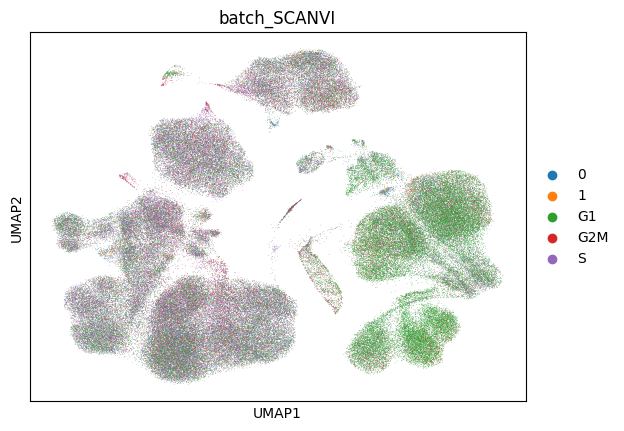

In [45]:
sc.pl.umap(adata, color=batch_keys, title="batch_SCANVI")

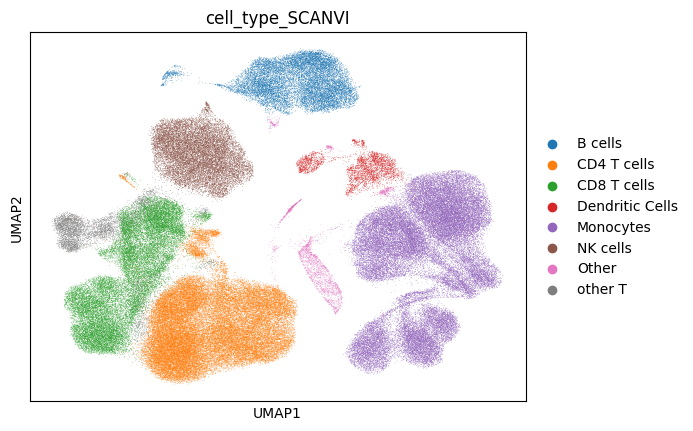

In [46]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCANVI")

In [47]:
inference_datamodule_scanvi = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    batch_size=8192,
    model_name="SCANVI",
    join="inner",
)
inference_datamodule_scanvi.setup(stage="inference")

In [48]:
adata.obs["predictions_scanvi"] = model_scanvi.predict(
    dataloader=inference_scanvi_dataloader, batch_size=1024
)

In [49]:
# proves the problem is in model not dataloder
# model_census4.predict(adata=None,dataloader=inference_datamodule_scanvi.inference_dataloader(shuffle=False))

In [50]:
# model_scanvi.predict(dataloader=inference_datamodule_scanvi.inference_dataloader(batch_size=8192))

In [51]:
# model_scanvi.predict(dataloader=inference_datamodule_scanvi.inference_dataloader())

In [52]:
adata.obs["cell_type"]

AAACCTGAGCTAGTGG-1       CD4 T cells
AAACCTGCACATTAGC-1       CD4 T cells
AAACCTGCACTGTTAG-1         Monocytes
AAACCTGCATAGTAAG-1         Monocytes
AAACCTGCATGAACCT-1       CD8 T cells
                            ...     
E2L8_TTTGTTGGTCGTGATT    CD8 T cells
E2L8_TTTGTTGGTGTGCCTG      Monocytes
E2L8_TTTGTTGGTTAGTTCG        B cells
E2L8_TTTGTTGGTTGGCTAT      Monocytes
E2L8_TTTGTTGTCTCATGGA      Monocytes
Name: cell_type, Length: 164084, dtype: category
Categories (8, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'Dendritic Cells', 'Monocytes', 'NK cells', 'Other', 'other T']

In [53]:
adata.obs["predictions_scanvi"]

AAACCTGAGCTAGTGG-1       CD4 T cells
AAACCTGCACATTAGC-1       CD4 T cells
AAACCTGCACTGTTAG-1         Monocytes
AAACCTGCATAGTAAG-1         Monocytes
AAACCTGCATGAACCT-1       CD8 T cells
                            ...     
E2L8_TTTGTTGGTCGTGATT    CD8 T cells
E2L8_TTTGTTGGTGTGCCTG      Monocytes
E2L8_TTTGTTGGTTAGTTCG        B cells
E2L8_TTTGTTGGTTGGCTAT      Monocytes
E2L8_TTTGTTGTCTCATGGA      Monocytes
Name: predictions_scanvi, Length: 164084, dtype: object

/tmp/ipykernel_2629600/1595341984.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

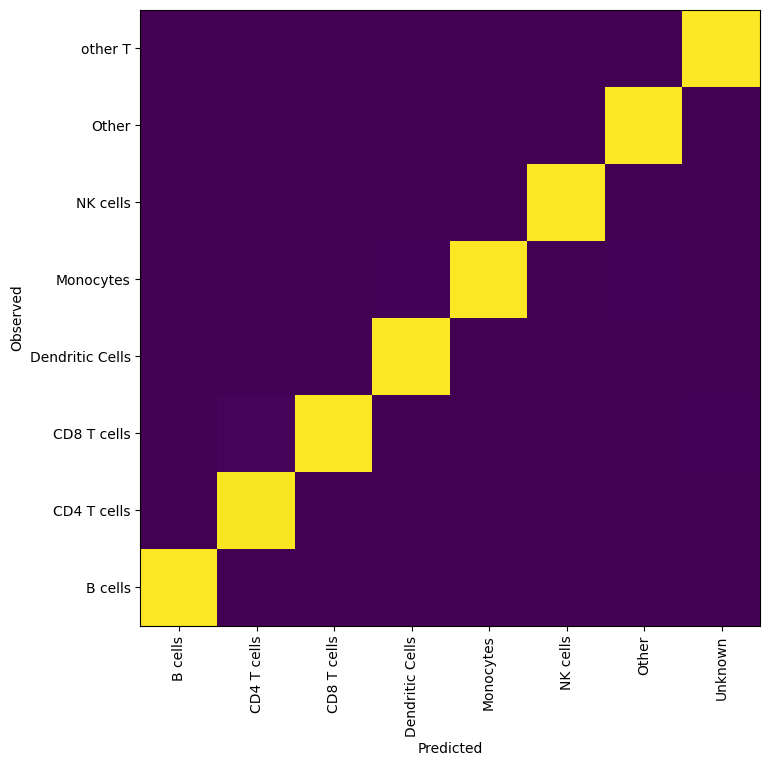

In [54]:
df = adata.obs.groupby(["cell_type", "predictions_scanvi"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

# run regulary using adata and compare

In [55]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [56]:
# sc.pp.highly_variable_genes(
#    adata,
#    n_top_genes=top_n_hvg,
#    subset=True,
#    layer="counts",
#    flavor="seurat_v3",
#    batch_key="dataset_id",
# )

In [57]:
adata.obs

,batch,cell_type,artifact_uid,predictions_scanvi
AAACCTGAGCTAGTGG-1,0,CD4 T cells,M18k5o0Xe3qDFjOv0005,CD4 T cells
AAACCTGCACATTAGC-1,0,CD4 T cells,M18k5o0Xe3qDFjOv0005,CD4 T cells
AAACCTGCACTGTTAG-1,0,Monocytes,M18k5o0Xe3qDFjOv0005,Monocytes
AAACCTGCATAGTAAG-1,0,Monocytes,M18k5o0Xe3qDFjOv0005,Monocytes
AAACCTGCATGAACCT-1,0,CD8 T cells,M18k5o0Xe3qDFjOv0005,CD8 T cells
...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,S,CD8 T cells,1DZ49fivMXjvwSiO0004,CD8 T cells
E2L8_TTTGTTGGTGTGCCTG,G1,Monocytes,1DZ49fivMXjvwSiO0004,Monocytes
E2L8_TTTGTTGGTTAGTTCG,S,B cells,1DZ49fivMXjvwSiO0004,B cells
E2L8_TTTGTTGGTTGGCTAT,G1,Monocytes,1DZ49fivMXjvwSiO0004,Monocytes


In [58]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", layer="counts")

In [59]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [60]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 480.96 seconds


In [61]:
model_census3.history["elbo_train"]

,elbo_train
epoch,
0,2034.779419
1,1952.667969
2,1915.128906
3,1891.891235
4,1878.13269
...,...
95,1828.116333
96,1828.03125
97,1827.96228


In [62]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

In [63]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")

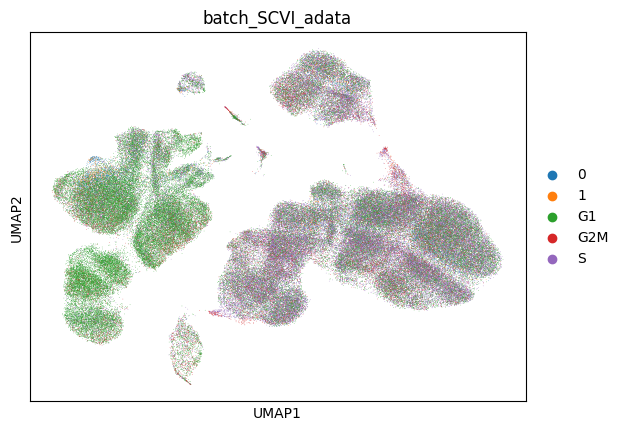

In [64]:
sc.pl.umap(adata, color="batch", title="batch_SCVI_adata")

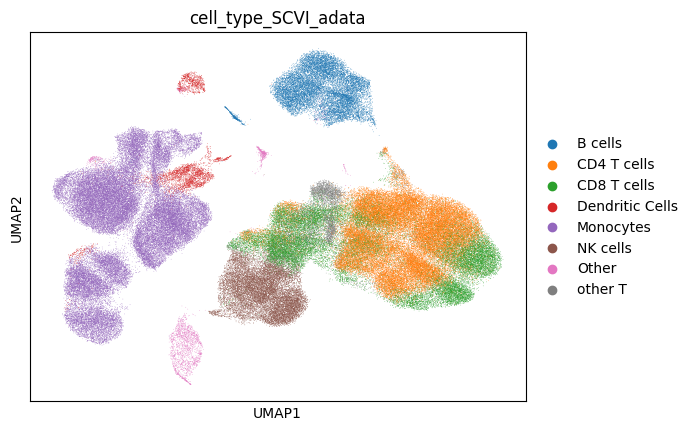

In [65]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI_adata")

## scanvi

In [66]:
adata

AnnData object with n_obs × n_vars = 164084 × 3315
    obs: 'batch', 'cell_type', 'artifact_uid', 'predictions_scanvi', '_scvi_batch', '_scvi_labels'
    uns: 'scvi', 'umap', 'batch_colors', 'cell_type_colors', 'scanvi', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'scvi_non_dataloder'
    obsm: 'scvi', 'X_umap', 'scanvi', 'scvi_non_dataloder'
    layers: 'counts'
    obsp: 'scvi_distances', 'scvi_connectivities', 'scanvi_distances', 'scanvi_connectivities', 'scvi_non_dataloder_distances', 'scvi_non_dataloder_connectivities'

In [67]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    labels_key="cell_type",
    unlabeled_category="label_0",
    batch_key=batch_keys,
)

In [68]:
# model_census4 = scvi.model.SCVI.load("census_model", adata=adata)
model_census4 = scvi.model.SCANVI(adata)

In [69]:
start4 = time.time()
model_census4.train(
    max_epochs=100,
)
end4 = time.time()
print(f"Elapsed time: {end4 - start4:.2f} seconds")

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 1139.10 seconds


In [70]:
model_census4.history["train_accuracy"]

,train_accuracy
epoch,
0,0.934065
1,0.965573
2,0.972501
3,0.97697
4,0.979787
...,...
95,0.997664
96,0.99744
97,0.997657


In [71]:
adata.obsm["scanvi_non_dataloder"] = model_census4.get_latent_representation()

In [72]:
sc.pp.neighbors(adata, use_rep="scanvi_non_dataloder", key_added="scanvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scanvi_non_dataloder")

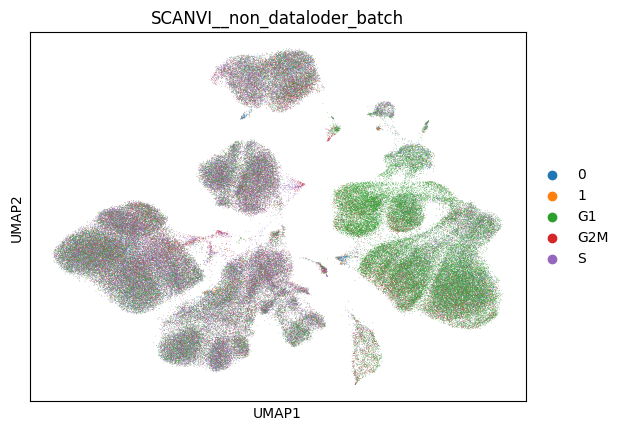

In [73]:
sc.pl.umap(adata, color=["batch"], title=["SCANVI__non_dataloder_" + x for x in ["batch"]])

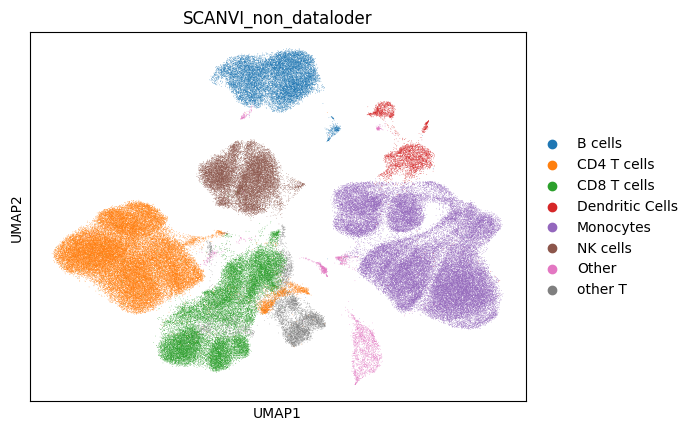

In [74]:
sc.pl.umap(adata, color="cell_type", title="SCANVI_non_dataloder")

In [75]:
adata.obs["predictions_scanvi_non_dataloder"] = model_census4.predict()

/tmp/ipykernel_2629600/704304115.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

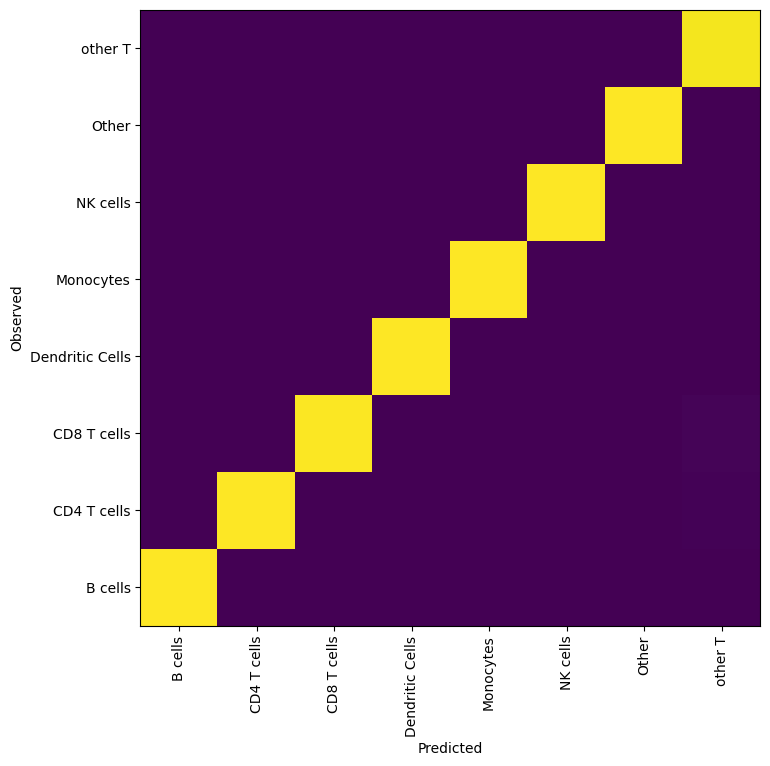

In [76]:
df = (
    adata.obs.groupby(["cell_type", "predictions_scanvi_non_dataloder"])
    .size()
    .unstack(fill_value=0)
)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

Compute integration metrics

In [77]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scvi", "scanvi", "scvi_non_dataloder", "scanvi_non_dataloder"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:17<00:08,  2.25s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:18<00:05,  1.92s/it, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  20%|███████████████████████▊                                                                                               | 1/5 [00:18<01:15, 18.87s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:07<00:02,  1.19it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  40%|███████████████████████████████████████████████▌                                                                       | 2/5 [00:26<00:36, 12.19s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.33it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 3/5 [00:32<00:19,  9.64s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.34it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4/5 [00:39<00:08,  8.43s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.34it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.23s/it]

                                                                                                                                                                   

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


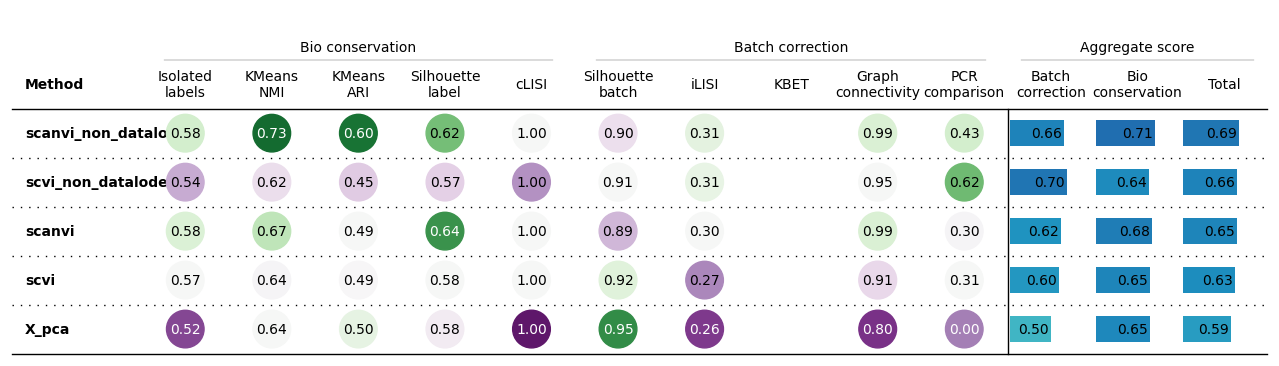

In [78]:
bm.plot_results_table(min_max_scale=False)